In [20]:
import numpy as np 
import math 
import matplotlib.pyplot as plt 
# from bandits import bandit
from multiprocessing import Pool
from random import random, randint


In [19]:
class bandit_arm:
    """
    Creates an arm which is a part of a bandit instance.
    """
    def __init__(self,arm_mean):
        self.arm_mean = arm_mean 

    def pull(self):
        return np.random.binomial(1,self.arm_mean)
    

class bandit:
    """
    Creates a (Bernoulli) bandit instance, which is fully specified by a list of arm means. 
    Functions:
        - pull(index) pulls the arm referred to by the index 
        - regret() provides the incurred regret on the bandit instance 

    NOTE: You cannot use the list of probabilities while running your algorithm! That is the whole point -- to determine those probabilities by interacting with the bandit instance again and again "efficiently".
    """
    def __init__(self,list_of_means):
        self.arms = [bandit_arm(prob) for prob in list_of_means]
        self.max_mean = max(list_of_means)
        self.regret = 0.0 
        self.count = 0 
        self.avg_reward = 0.0

    def pull(self,index):
        reward = self.arms[index].pull()
        self.regret = self.regret + (self.max_mean - reward)
        self.count += 1 
        if(self.count > 1):
            self.avg_reward = (self.avg_reward*(self.count - 1) + reward)/(self.count)
        elif(self.count == 1):
            self.avg_reward = reward
        return reward 

    def regret(self):
        return self.regret 
    
    def avg_reward(self):
        return self.avg_reward


In [21]:
class Algorithm:
    def __init__(self, num_arms):
        self.num_arms = num_arms
    
    def give_pull(self):
        raise NotImplementedError
    
    def get_reward(self, arm_index, reward):
        raise NotImplementedError

## $\epsilon$-greedy algorithms

There are different variants of $\epsilon$-greedy algorithms, which illustrate the ideas of exploration and exploitation in reinforcement learning. Here, you are to implement an algorithm which explores with probability $\epsilon$ and exploits with probability $1-\epsilon$. Wherein, exploration means uniformly sampling from the list of arms, and exploitation is the act of sampling the arm with the highest empirical mean. 

The algorithm needs to be implemented as a class which has three functions: 
- Initialization: Initialize all the data structures (including your $\epsilon$) here. 
- Pull: Return the index of the arm that needs to be pulled as per this algorithm. 
- Get reward: The bandit instance will tell you the reward -- this function needs to update the internal data structures of the algorithm so as to process that reward.

In [33]:
# Implement the epsilon greedy algorithm 
# as a child class of the Algorithm class
class eps_greedy(Algorithm):
    def __init__(self,num_arms):
        super().__init__(num_arms)
        self.epsilon=0.5
        self.num_arms=num_arms
        self.rewards=np.zeros(num_arms)  #List storing the average rewards
        self.k=np.zeros(num_arms) #List storing the counter variable k, for calculating Qk or Q(k+1)
        

    def give_pull(self):
        # write the code to give a pull via the epsilon greedy algo 
        probab=random()
        if probab<=self.epsilon:
            # at=int(probab//(self.epsilon/self.num_arms))
            at= randint(0,self.num_arms-1)
            # self.epsilon=(1-self.epsilon)/2
        else:
            # avg_mean=np.zeros(self.num_arms)
            # for bandit in range(self.num_arms):
            #   if self.k[bandit]:
            #     avg_mean[bandit]=self.rewards[bandit]/self.k[bandit]
                
            #   else:
            #     avg_mean[bandit]=0
            at=np.argmax(avg_mean)
            # self.epsilon=(1+self.epsilon)/2
            
        return at
    
    def get_reward(self,arm_index,reward):
        # update the data structures based on the reward received
        self.k[arm_index]+=1
        
        self.rewards[arm_index]+=(reward-self.rewards[arm_index])/self.k[arm_index] #Assigning the value of Q(k+1) 
        # self.rewards[arm_index]+=rewards
        
        

## UCB Algorithm

Read about the UCB algorithm from Sutton and Barto, and implement it in the exact same format as the previous one. The operation to be performed is, 

$$a_t := \argmax_{a\in A}(q_t(a) + 3\sqrt{\frac{ln(t)}{N_t(a)}})$$

In [23]:
# Implement the UCB algorithm
class UCB(Algorithm):
    def __init__(self, num_arms):
        super().__init__(num_arms)
        self.num_arms=num_arms
        self.Nta=np.zeros(self.num_arms)
        self.Qta=np.zeros(self.num_arms)
        # write the necessary data structures here
    
    def give_pull(self):
        # write the code to give a pull via the epsilon greedy algo 
        at=np.argmax([self.Qta[bandit]+3*np.sqrt(bandit/self.Nta[bandit]) for bandit in range(self.num_arms)])
        return at
    
    def get_reward(self,index,reward):
        # update the data structures based on the reward received
        self.Qta[index]+=(reward-self.Qta[index])/self.num_arms
        self.Nta[index]+=1
        

## Thompson Sampling

This is another algorithm for sampling/pulling a MAB. Here, a list of successes ($s_t(a)$) and failures ($f_t(a)$) of the arms is maintained, and then the following samples are drawn for each arm, 

$$n_t(a) \sim \beta(s_t(a) +1,f_t(a)+1)$$

where $\beta$ denote the Beta Distribution. Then, the arm with the highest value of such a sample is chosen. That is, 
 
$$a_t := \argmax_{a\in A}n_t(a)$$

In the background, a _bayesian_ update is happening, which ensures that this algorithm works well. 

The code for this algorithm is already written, and you can use this as a reference for the structure of the other two.

In [24]:
class Thompson_Sampling(Algorithm):
    def __init__(self, num_arms):
        super().__init__(num_arms)
        #we write the required data structures for this algorithms
        self.successes = np.zeros(num_arms)
        self.failures = np.zeros(num_arms)
    
    def give_pull(self):
        # we give a rule according to the algorithm to sample the bandit instance
        beta = [np.random.beta(self.successes[bandit]+1,self.failures[bandit] +1) for bandit in range(self.num_arms)]
        return np.argmax(beta)
    
    def get_reward(self, arm_index, reward):
        # we update the data structures as we see the reward received
        self.successes[arm_index] += reward
        self.failures[arm_index] += (1-reward)


## Analysis

Here, code for the analysis of the thompson algorithm is written. Mainly, we use the _regret_ for analyzing the performance of an algorithm. The (expected cumulative) regret is the difference between the maximum possible reward and the expected reward from the algorithm. That is, 

$$R(T) := Tp^* - \sum_{t=0}^{T-1}\mathbb{E}(r_t)$$

where, $r_t$ is the reward at time $t\in\{0,1,...T-1\}$. 

We say that an algorithm here is 'good' if the regret is sub-linear, that is, 
$$\lim_{T\to\infty}\frac{R(T)}{T} = 0$$

The regret plots, along with the average reward plots for Thompson sampling are given below. Do the same for the other algorithms and compare.

In [25]:
#no need to modify anything here
def plot_avg_reward(algo,horizon,averaging=100):
    average_reward = np.zeros(horizon)
    for j in range(averaging):
        np.random.seed(0)
        bandit_instance = bandit([0.2,0.1,0.6,0.1]) # use this bandit instance only
        thompson_instance = algo(4) # do this for the other two algorithms as well
        rewards = [] 
        for i in range(horizon):
            arm_to_pull = thompson_instance.give_pull() #get the arm to pull _From the ALGORITHM_
            reward = bandit_instance.pull(arm_to_pull) #get the (stochastic) reward _from the BANDIT INSTANCE_
            thompson_instance.get_reward(arm_to_pull,reward) #update the internal data structures of the algorithm
            rewards.append(bandit_instance.avg_reward)
        average_reward = average_reward + rewards


    average_reward = average_reward/averaging 

    plt.plot(average_reward)
    plt.title("Average Reward")

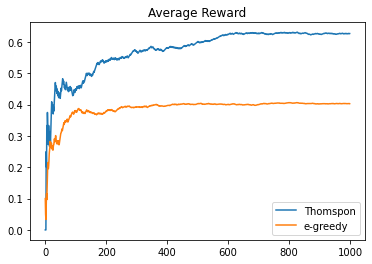

In [34]:
plot_avg_reward(Thompson_Sampling,1000)
plot_avg_reward(eps_greedy,1000)
plt.legend(["Thomspon","e-greedy"])

In [27]:
#no need to modify anything here
def single_sim(algo, list_of_means, horizon):
    np.random.seed(0)
    bandit_instance = bandit(list_of_means=list_of_means)
    algo_inst = algo(num_arms=len(list_of_means))
    for t in range(horizon):
      arm_to_be_pulled = algo_inst.give_pull()
      reward = bandit_instance.pull(arm_to_be_pulled)
      algo_inst.get_reward(arm_index=arm_to_be_pulled, reward=reward)
    return bandit_instance.regret

def simulate(algorithm, probs, horizon, num_sims=50):

    def multiple_sims(num_sims=50):
      with Pool(10) as pool:
        regrets = pool.starmap(single_sim,
          [(algorithm, probs, horizon) for i in range(num_sims)])
      return regrets

    return np.mean(multiple_sims(num_sims))
def plot_regret(algo,list_of_means):  
  horizons = [2**i for i in range(10, 18)]
  regrets = []
  for horizon in horizons:
    regrets.append(simulate(algo, list_of_means, horizon, 20))

  print(regrets)
  plt.plot(horizons, regrets)
  plt.title("Regret vs Horizon")

[-31.599999999999575, -38.19999999999812, -22.39999999999521, -43.79999999999207, -2.5999999999887473, 60.79999999999067, 129.599999999909, 307.2000000005104]
[200.49999999999628, 416.95000000001147, 809.6000000000583, 1616.2499999998147, 3172.5499999990666, 6441.950000002967, 12994.250000014876, 26266.049999949988]


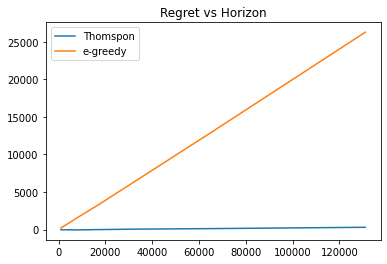

In [36]:
plot_regret(Thompson_Sampling,[0.2,0.1,0.6,0.1])
plot_regret(eps_greedy,[0.2,0.1,0.6,0.1])
plt.legend(["Thomspon","e-greedy"]) 